In [1]:
import torch
torch.cuda.empty_cache()
from datasets import load_dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import pandas as pd
import torch.nn as nn
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
set_seed(42)
device = "cpu" #"cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
#Get the dataset
snli = load_dataset("snli")

Found cached dataset snli (C:/Users/zebzi/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# per chatGPT's suggestion, let's concatenate premise + hypothesis into a "text" column.
train_text = np.char.add(np.char.add(snli['train']['premise'], ' '), snli['train']['hypothesis'])
test_text = np.char.add(np.char.add(snli['test']['premise'], ' '), snli['test']['hypothesis'])
valid_text = np.char.add(np.char.add(snli['validation']['premise'], ' '), snli['validation']['hypothesis'])

# let's do a sanity check to make sure concatenation was done correctly
print(f'--train_text[0]--: {train_text[0]}')
print(f'--original + hypothesis--: {snli["train"]["premise"][0]+snli["train"]["hypothesis"][0]}\n')

print(f'--test_text[0]--: {test_text[0]}')
print(f'--original + hypothesis--: {snli["test"]["premise"][0]+snli["test"]["hypothesis"][0]}\n')

print(f'--valid_text[0]--: {valid_text[0]}')
print(f'--original + hypothesis--: {snli["validation"]["premise"][0]+snli["validation"]["hypothesis"][0]}')

snli["train"] = snli["train"].remove_columns(["premise", "hypothesis"])
snli["train"] = snli["train"].add_column("text", train_text)

snli["test"] = snli["test"].remove_columns(["premise", "hypothesis"])
snli["test"] = snli["test"].add_column("text", test_text)

snli["validation"] = snli["validation"].remove_columns(["premise", "hypothesis"])
snli["validation"] = snli["validation"].add_column("text", valid_text)

--train_text[0]--: A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.
--original + hypothesis--: A person on a horse jumps over a broken down airplane.A person is training his horse for a competition.

--test_text[0]--: This church choir sings to the masses as they sing joyous songs from the book at a church. The church has cracks in the ceiling.
--original + hypothesis--: This church choir sings to the masses as they sing joyous songs from the book at a church.The church has cracks in the ceiling.

--valid_text[0]--: Two women are embracing while holding to go packages. The sisters are hugging goodbye while holding to go packages after just eating lunch.
--original + hypothesis--: Two women are embracing while holding to go packages.The sisters are hugging goodbye while holding to go packages after just eating lunch.


In [5]:
snli = snli.filter(lambda example: example["label"] != -1)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# tokenizer.to('cuda')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
    
tokenized_snli= snli.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-a7e3f6a12dd5470b.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-10263cd2a97d376b.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-7dd2e0b9c4e30d43.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-6a07a2c8d2f1ad8c.arrow
Loading cached processed dataset at C:\Users\zebzi\.cache\huggingface\datasets\snli\plain_text\1.0.0\1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b\cache-aa9d2d1182cd7304.arrow
Loading cached processed 

In [6]:
# Load the model that was trained in HW1
id2label = {0: "entailment", 1: "neutral", 2:"contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}

config = AutoConfig.from_pretrained("config.json")
model = AutoModelForSequenceClassification.from_pretrained("pytorch_model.bin", config=config)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [9]:
# Load the pipeline for natural language inference tasks
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
count = 0
i = 0

#Get the indices of the correctly predicted and incorrectly predicted examples
correct_idxs = []
incorrect_idxs = []

#Get the embeddings of the correctly and incorrectly predicted examples
correct_vectors = []
contra = []
neutral = []
entail = []
incorrect_vectors = []

#Get the confidences
correct_conf = []
contra_conf = []
neutral_conf = []
entail_conf = []
incorrect_conf = []

rowsList = []
while(count < 50):
    try:
        temp = snli["test"]["text"][i+100].split(".")
        # print(tokenized_snli["test"]["text"][i + 100])
        premise = temp[0]
        hypothesis = temp[1]
    except:
        print("no period\n")

    with torch.no_grad():
        outputs = tokenizer(snli["test"]["text"][i+100], return_tensors='pt', padding=True, truncation=True)
    # outputs = outputs.to('cuda:0')
        result = nlp.model(**outputs, output_hidden_states=True)
    # result = nlp(tokenized_snli["test"]["text"][i + 100])[0]'ArithmeticError

    # print(result["logits"].item())
    predicted_token_class_ids = result.logits.argmax(-1)
    predicted_label = nlp.model.config.id2label[predicted_token_class_ids.item()]
    # dumb = result.logits.detach().cpu()
    # dumb = np.array((result.logits[0][0].item(), result.logits[0][1].item(), result.logits[0][2].item()))
    probability = np.exp(result.logits[0].detach().cpu().numpy()) / np.sum(np.exp(result.logits[0].detach().cpu().numpy()))
    
    # probability = 1 - probability[tokenized_snli['test']['label'][i+100]]
    # print(probability)
    # print(result["hidden_states"][-1][-1][0:10].flatten().shape)
    hidden_layer = result["hidden_states"][-1][-1][0:10].flatten().numpy()
    temp = []
    # print(f"predicted_label: {predicted_label} and actual label: {id2label[tokenized_snli['test']['label'][i+100]]} with confidence: {probability[tokenized_snli['test']['label'][i+100]]:.3f}")
    if(predicted_label != id2label[tokenized_snli["test"]["label"][i+100]]):
        incorrect_idxs.append(i)
        incorrect_vectors.append(hidden_layer)
        count += 1
        incorrect_conf.append(probability)

        # print()
        # print("Premise: ",end="")
        # print(premise)
        # print("Hypothesis: ",end="")
        # print(hypothesis)
        # print(f"Confidence: {probability}")#{1 - probability[tokenized_snli['test']['label'][i+100]]:.3f}")
        # print("The prediction is: ", predicted_label)
        # print("The correct is: ", id2label[tokenized_snli["test"]["label"][i+100]])
        # temp = [str(count), f"Premise: {premise} \nHypothesis: {hypothesis}", id2label[tokenized_snli["test"]["label"][i+100]], f"Confidence: {result['score']:.3f} \n" + result['label'], str(len(premise) + len(hypothesis))]
        # rowsList.append(temp)
    else:
        if(id2label[tokenized_snli["test"]["label"][100+i]] == "entailment"):
            entail.append(hidden_layer)
            entail_conf.append(probability)

        elif(id2label[tokenized_snli["test"]["label"][100+i]] == "neutral"):
            neutral.append(hidden_layer)
            neutral_conf.append(probability)

        elif(id2label[tokenized_snli["test"]["label"][100+i]] == "contradiction"):
            contra.append(hidden_layer)
            contra_conf.append(probability)

        correct_idxs.append(i)
        correct_conf.append(probability)
        correct_vectors.append(hidden_layer)
    i += 1

# with open("hw5CSV.csv", mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["", "Input Text", "Ground-Truth Label", "Predicted Label", "Input Text Length"])
#     writer.writerows(rowsList)
# print("Here is i: ", i)

In [14]:
# max_length = max(len(row) for row in enumerate(contra, neutral, entrail))

pca = PCA(n_components=2)
# print(len(contra[0][0]))
print(f"contra size: {len(contra)} and neutral: {len(neutral)} and entail: {len(entail)} and incorrect: {len(incorrect_vectors)}")
pca.fit(np.concatenate((contra,neutral,entail,incorrect_vectors)))
# pca = pca.fit(np.array(contra))
# pca = pca.fit(np.array(neutral))
# pca = pca.fit(np.array(entail))
# pca = pca.fit(np.array(incorrect_vectors))

# correct_vectors_2d = pca.transform(correct_vectors)
contra_vec_2d = pca.transform(np.array(contra))
neutral_vec_2d = pca.transform(np.array(neutral))
entail_vec_2d = pca.transform(np.array(entail))
incorrect_vectors_2d = pca.transform(np.array(incorrect_vectors))

contra size: 139 and neutral: 128 and entail: 142 and incorrect: 50


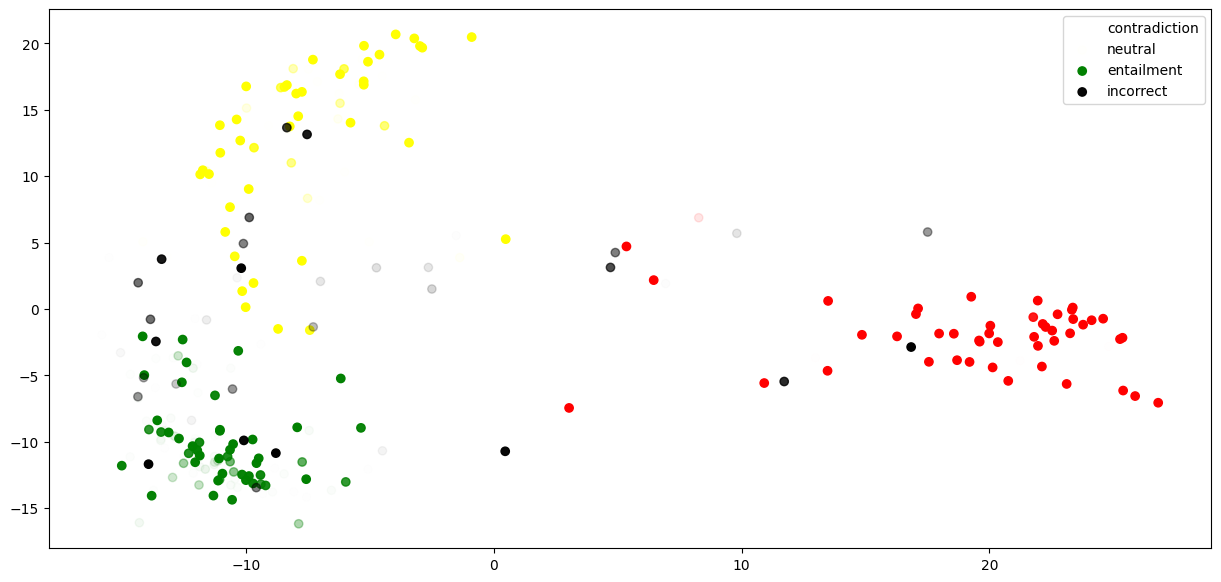

In [15]:
# Plot the 2-dimensional scatter plot

plt.scatter(contra_vec_2d[:, 0], contra_vec_2d[:, 1], c='red', alpha=contra_conf, label='contradiction')
plt.scatter(neutral_vec_2d[:, 0], neutral_vec_2d[:, 1], c='yellow', alpha=neutral_conf, label='neutral')
plt.scatter(entail_vec_2d[:, 0], entail_vec_2d[:, 1], c='green', alpha=entail_conf, label='entailment')
plt.scatter(incorrect_vectors_2d[:, 0], incorrect_vectors_2d[:, 1], c='black', alpha=incorrect_conf, label='incorrect')
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# for i in range(len(contra_vec_2d)):
#   ax.scatter(contra_vec_2d[i,0], contra_vec_2d[i,1], contra_vec_2d[i,2], color='r', alpha=contra_conf[i])

# for i in range(len(neutral_vec_2d)):
#   ax.scatter(neutral_vec_2d[i,0], neutral_vec_2d[i,1], neutral_vec_2d[i,2], color='yellow', alpha=neutral_conf[i])

plt.rcParams['figure.figsize'] = (15, 7)

# plt.scatter(contra_vec_2d[:, 0], contra_vec_zero, c='r', alpha=contra_conf, label='contradiction', s=10)
# plt.scatter(neutral_vec_2d[:, 0], neutral_vec_zero, c='yellow', alpha=neutral_conf, label='neutral', s=10)
# plt.scatter(entail_vec_2d[:, 0], entail_vec_zero, c='green', alpha=entail_conf, label='entailment', s=10)
# plt.scatter(incorrect_vectors_2d[:, 0], incorrect_vec_zero, c='black', alpha=incorrect_conf, label='incorrect', s=10)

# plt.scatter(contra_avg, [0], c='r',label="contradiction average", s=200)
# plt.scatter(neutral_avg, [0], c='yellow',label="contradiction average", s=200)
# plt.scatter(entail_avg, [0], c='green',label="contradiction average", s=200)
# plt.scatter(incorrect_avg, [0], c='black',label="contradiction average", s=200)
plt.legend(loc='best')
plt.show()